#Задача 
Объект описывается уравнением вида  $y(i) = a_1x_1(i)+a_2x_2(i)+a_3x_3(i)+\eta(i)$  
$x_i, i \in{1,2,3}$ - параметры входа, имеющие нормальный закон распределения  
$\eta(i)$ - шум, подчиняющийся нормальному закону распределения  
$y(i)$ - выход объекта  

По известным входам и выходам объекта оценить параметры объекта $a_1,a_2,a_3$.  



---


*Данные для тестового моделирования:  
$M(x_1)=10.5, M(x_2)=3.4, M(x_3)=12.6$  
$a_1=2.3,a_2=4.8,a_3=1$*

In [653]:
import numpy as np
from scipy import linalg

##Генерация априорной информации

In [654]:
def gen_vals(mean, var, N, trans):
  if len(mean) != len(var):
    print("Different sizes!")
    return None
  vals = list()
  for i in range (len(mean)):
    vals.append(np.random.normal(loc=mean[i], scale = np.sqrt(var[i]), size=N))
  return np.transpose(vals) if trans else vals 

In [655]:
a_mean = np.array([2.3, 4.8, 1.])
a_var = np.array([0.1, 0.1, 0.1])
a_N = 20

In [656]:
a_val = gen_vals(a_mean, a_var, a_N, False)

### Вычисление выборочных параметров распределений

In [657]:
a_mean = np.array([x.mean() for x in a_val])
a_var = np.array([x.var(ddof=1) for x in a_val])

In [658]:
print('Оценка параметров распредления вектора параметров')
for i in range(len(a_var)):
  print('a{0}~N({1:3.2f},{2:3.2f})'.format(i, a_mean[i], a_var[i]))

Оценка параметров распредления вектора параметров
a0~N(2.32,0.16)
a1~N(4.75,0.08)
a2~N(0.95,0.11)


##Генерация входов

In [659]:
U_mean = np.array([10.5,3.4,12.6])
U_var = np.array([30,30,30])
N = 12

In [660]:
U_val = gen_vals(U_mean, U_var, N, True)

In [661]:
import matplotlib.pyplot as plt

In [662]:
plt.rcParams["figure.dpi"] = 90

In [663]:
def drawU(points, U,label,color, U_mean,mean_label):
  plt.scatter(points, U, label=label, color=color)
  plt.plot([1, N], [U_mean, U_mean], label=mean_label, color=color)


Text(0, 0.5, 'Входное значение, ед.')

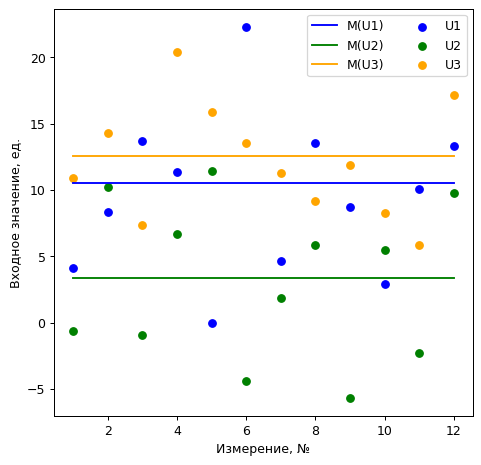

In [664]:
plt.rcParams["figure.figsize"] = (6,6)
points = np.linspace(1,N,N)

drawU(points, U_val[:,0],'U1', 'blue', U_mean[0], 'M(U1)')
drawU(points, U_val[:,1],'U2', 'green', U_mean[1], 'M(U2)')
drawU(points, U_val[:,2],'U3', 'orange', U_mean[2], 'M(U3)')

plt.legend(ncol=2)
plt.xlabel('Измерение, №')
plt.ylabel('Входное значение, ед.')

##Выходы объекта

In [665]:
def y(U,b,e):
  return np.matmul(U,b)+e

In [666]:
a_real = np.array([2.3, 4.8, 1.])

###Генерация шума

In [667]:
e_var = 2

In [668]:
e = np.random.normal(scale=e_var, size=N)

Text(0, 0.5, 'Значение шума, ед.')

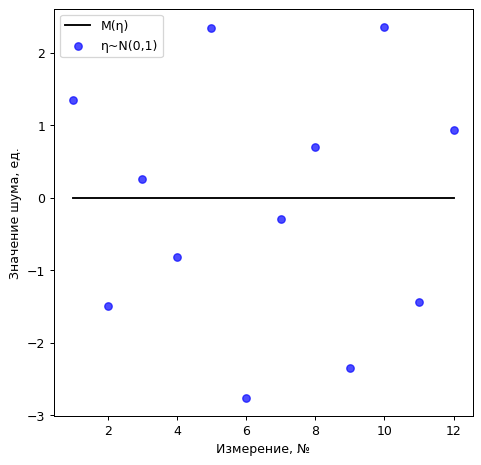

In [669]:
points = np.linspace(1,N,N)

plt.scatter(points, e, label='\u03B7~N(0,1)', color='blue', alpha = 0.7)
plt.plot([1,N], [0,0], label='M(\u03B7)', color='black')

plt.legend()
plt.xlabel('Измерение, №')
plt.ylabel('Значение шума, ед.')

###Формирование выходов

In [670]:
y_val = y(U_val,a_real,e)

#Оценка параметров методом максимума апостериорной вероятности
Формула Байеса: $$\displaystyle p(\vec{c}=\tilde{\vec{c}}|\vec{y})=\frac{p(\vec{y}|\tilde{\vec{c}})p(\vec{c}=\tilde{\vec{c}})}{p(\vec{y})}$$  
$$J(\tilde{\vec{c}}) = [-ln\ p(\vec{y}|\tilde{\vec{c}})-ln\ p(\tilde{\vec{c}}))] \rightarrow min$$

Пусть $$\vec{\eta}\sim N(0,D_{\eta}),\ \vec{a}\sim N(\vec{\mu_{a}},D_{a}),$$ тогда $$ \hat{\vec{a}}_{MAP} = (U^{*T}R^*U^*)^{-1}U^{*T}R\vec{y}^*,$$

где $$\begin{equation}\begin{split}
U^* &= \begin{pmatrix}
U\\
I_m\\
\end{pmatrix},
\vec{y}^* &= \begin{pmatrix}
\vec{y}\\
\vec{\mu}_a\\
\end{pmatrix},
R^* &= \begin{pmatrix}
D_{\eta}^{-1}&0\\
0&D_{a}^{-1}\\
\end{pmatrix},
\end{split}\end{equation}$$

или $$ \hat{\vec{a}}_{MAP} = (U^{T}D_{\eta}^{-1}U+D_{a}^{-1})^{-1}(U^{T}D_{\eta}^{-1}\vec{y}+D_{a}^{-1}\vec{\mu}_a)$$

In [671]:
#@title LS(U,R,y)
def LS(U,R,y):
  Ut = np.transpose(U)
  UtR =  Ut.dot(R)
  UtRU = UtR.dot(U)
  UtRU_inv = np.linalg.inv(UtRU)
  UtRU_invUtR = (UtRU_inv.dot(Ut)).dot(R)
  return UtRU_invUtR.dot(y)

###Отсутствие априорной информации

In [672]:
D_e = np.eye(N)
for i in range(N):
  D_e[i,i] = e_var
D_e_inv = linalg.inv(D_e) 
a_LS = LS(U_val,D_e_inv,y_val)
a_LS

array([2.22872905, 4.95652047, 0.99304306])

### Присутствие априорной информации

In [673]:
a_len = len(a_real)

In [674]:
U_star = np.concatenate((U_val,np.eye(a_len)),axis=0)

In [675]:
mu_a = a_mean
y_star = np.concatenate((y_val,mu_a),axis=0)

In [676]:
D_eta = D_e
D_a = np.eye(a_len)
for i in range(a_len):
  D_a[i,i] = a_var[i]
print(D_a)

[[0.16345415 0.         0.        ]
 [0.         0.08165879 0.        ]
 [0.         0.         0.10643853]]


In [677]:
R_eta = np.concatenate( (np.linalg.inv(D_eta), np.zeros((N,a_len)) ), axis=1)
R_a = np.concatenate( (np.zeros((a_len,N)), np.linalg.inv(D_a) ), axis=1)
R = np.concatenate((R_eta,R_a), axis=0)

In [678]:
for i in range(R.shape[0]):
  for j in range(R.shape[1]):
    print("{0:3.2f}".format(R[i,j]), end='\t')
    if j == D_eta.shape[1]-1:
      print("|", end='\t')
  print()
  if i == D_eta.shape[0]-1:
    for j in range(R.shape[1]+1):
      print("----", end='\t')
    print()

0.50	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	|	0.00	0.00	0.00	
0.00	0.50	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	|	0.00	0.00	0.00	
0.00	0.00	0.50	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	|	0.00	0.00	0.00	
0.00	0.00	0.00	0.50	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	|	0.00	0.00	0.00	
0.00	0.00	0.00	0.00	0.50	0.00	0.00	0.00	0.00	0.00	0.00	0.00	|	0.00	0.00	0.00	
0.00	0.00	0.00	0.00	0.00	0.50	0.00	0.00	0.00	0.00	0.00	0.00	|	0.00	0.00	0.00	
0.00	0.00	0.00	0.00	0.00	0.00	0.50	0.00	0.00	0.00	0.00	0.00	|	0.00	0.00	0.00	
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.50	0.00	0.00	0.00	0.00	|	0.00	0.00	0.00	
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.50	0.00	0.00	0.00	|	0.00	0.00	0.00	
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.50	0.00	0.00	|	0.00	0.00	0.00	
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.50	0.00	|	0.00	0.00	0.00	
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.50	|	0.00	0.00	0.00	
----	----	----	----	----	----	----	----	----	----	----	----	----

In [679]:
a_MAP = LS(U_star,R,y_star)

In [680]:
a_MAP

array([2.22575329, 4.94073586, 0.99938321])

##Сравнение отклонений от истинных значений оценок, полученных МНК и МАВ

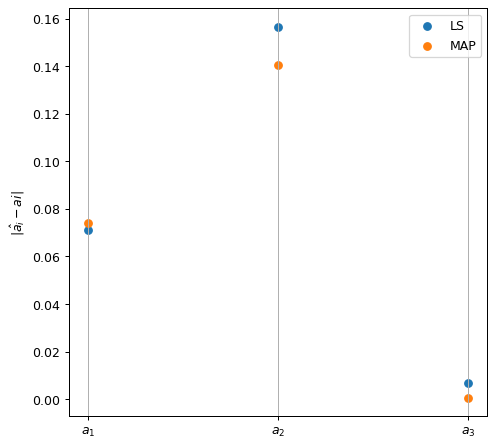

In [681]:
coef_n = [r'$a_1$',r'$a_2$',r'$a_3$']
plt.scatter(coef_n, abs(a_LS-a_real), label='LS')
plt.scatter(coef_n, abs(a_MAP-a_real), label='MAP')
# plt.scatter(coef_n, abs(a_mean-a_real), label=r'$\mu(a_i)$')
plt.xticks(coef_n)
plt.grid(axis='x')
plt.ylabel(r'$|\hat{a_i}-ai|$')
plt.legend(loc='best')
None

##Адекватность моделей

In [682]:
from scipy.stats import cramervonmises_2samp

ImportError: ignored

https://scipy.github.io/devdocs/release.1.7.0.html

In [ ]:
import scipy
print(scipy.__version__)

In [ ]:
!pip install scipy==1.7.0

In [ ]:
cramervonmises_2samp(np.matmul(U_val, a_MAP.reshape(3,1)).reshape(12,), y_val)

In [ ]:
cramervonmises_2samp(np.matmul(U_val, a_LS.reshape(3,1)).reshape(12,), y_val)